## ARIMA Forecasting and LSTM Prediction for GOOGLE

## Explanation of the notebook
I focused on analyzing and forecasting stock price trends for Google (GOOGL) using both traditional time series models and deep learning. The workflow begins by loading historical GOOGL stock data from a Kaggle dataset spanning 2006 to 2018. A Kalman Filter is applied first to smooth noisy price fluctuations and overlay a moving average on candlestick charts using mplfinance. The analysis then progresses to ARIMA modeling, where auto_arima is used to automatically determine the best-fitting parameters for time series forecasting. A six-month forecast is generated and plotted, highlighting expected future trends. Lastly, the notebook implements a Long Short-Term Memory (LSTM) neural network in TensorFlow/Keras to learn temporal dependencies from past price sequences and predict future values.



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Install Required Packages

In [21]:
#! pip install yfinance pykalman matplotlib
#! pip install mplfinance

Download the data

In [17]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("szrlee/stock-time-series-20050101-to-20171231")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/stock-time-series-20050101-to-20171231


Import required packages and load the data

In [19]:
# Import required libraries
import yfinance as yf
from matplotlib import pyplot as plt
from pykalman import KalmanFilter
import numpy as np
import datetime
import pandas as pd
import mplfinance as mpf

In [20]:
# Load CSV
file_path = '/kaggle/input/stock-time-series-20050101-to-20171231/GOOGL_2006-01-01_to_2018-01-01.csv'
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()

Kalman Filter

In [22]:
# Apply Kalman Filter on Close prices
kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=0,
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=0.01
)

filtered_close, _ = kf.filter(df['Close'].values)
df['Kalman_MA'] = filtered_close

/usr/local/lib/python3.11/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


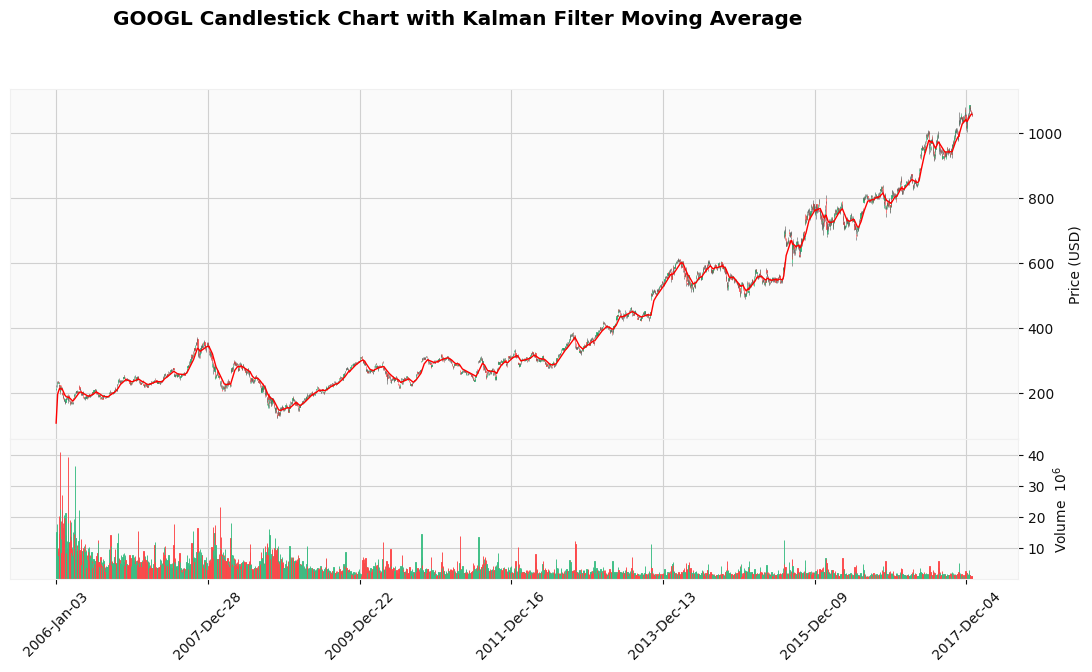

In [23]:
# Add Kalman line as overlay in the plot
apds = [mpf.make_addplot(df['Kalman_MA'], color='red', width=1.0)]

mpf.plot(
    df,
    type='candle',
    volume=True,
    style='yahoo',
    title='GOOGL Candlestick Chart with Kalman Filter Moving Average',
    ylabel='Price (USD)',
    addplot=apds,
    figsize=(14, 7)
)

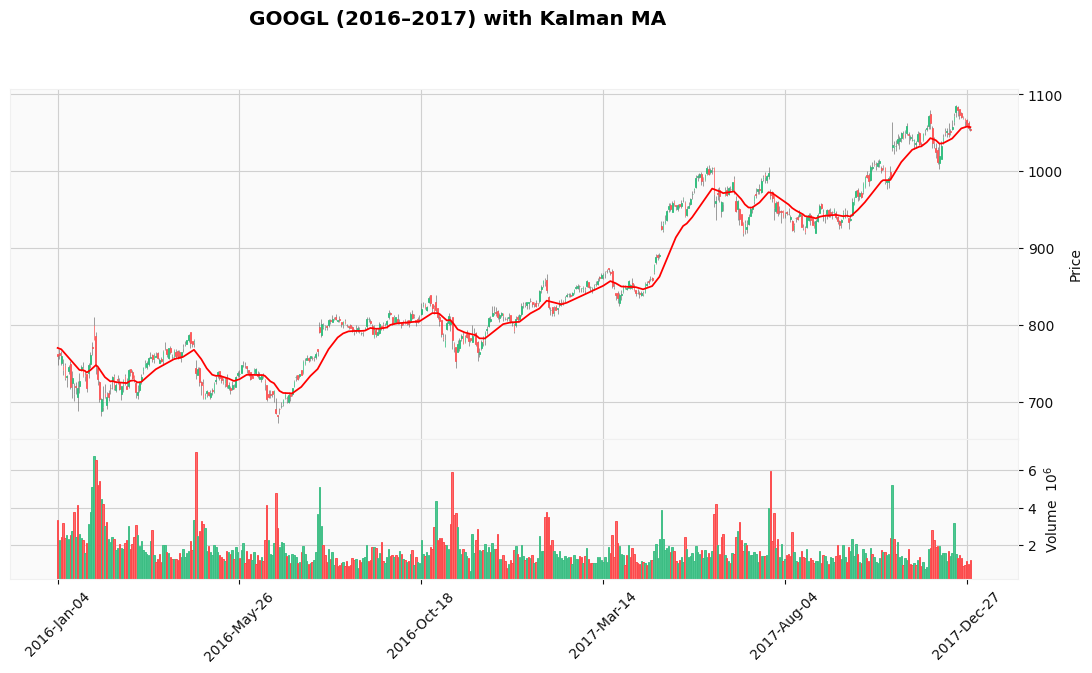

In [24]:
# 1 year Plot
zoomed = df.loc['2016-01-01':'2017-12-31']
mpf.plot(
    zoomed,
    type='candle',
    volume=True,
    style='yahoo',
    title='GOOGL (2016–2017) with Kalman MA',
    addplot=[mpf.make_addplot(zoomed['Kalman_MA'], color='red')],
    figsize=(14, 7)
)


### ARIMA Forecasting

In [39]:
#! pip install pmdarima

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [41]:
#Automatically find best (p,d,q)
stepwise_model = auto_arima(
    df['Close'],
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    seasonal=False,
    d=None, trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
print(f"Best ARIMA order: {stepwise_model.order}")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20235.366, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20234.993, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20235.055, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20238.208, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=20236.547, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20236.872, Time=1.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=20237.582, Time=1.69 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=20237.564, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 3.675 seconds
Best ARIMA order: (1, 1, 0)


In [43]:
model = ARIMA(df['Close'], order=stepwise_model.order)
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [44]:
# Forecast
forecast_days = 126  # ≈ 6 months business days
forecast = model_fit.forecast(steps=forecast_days)
forecast_index = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=forecast_days, freq='B')


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


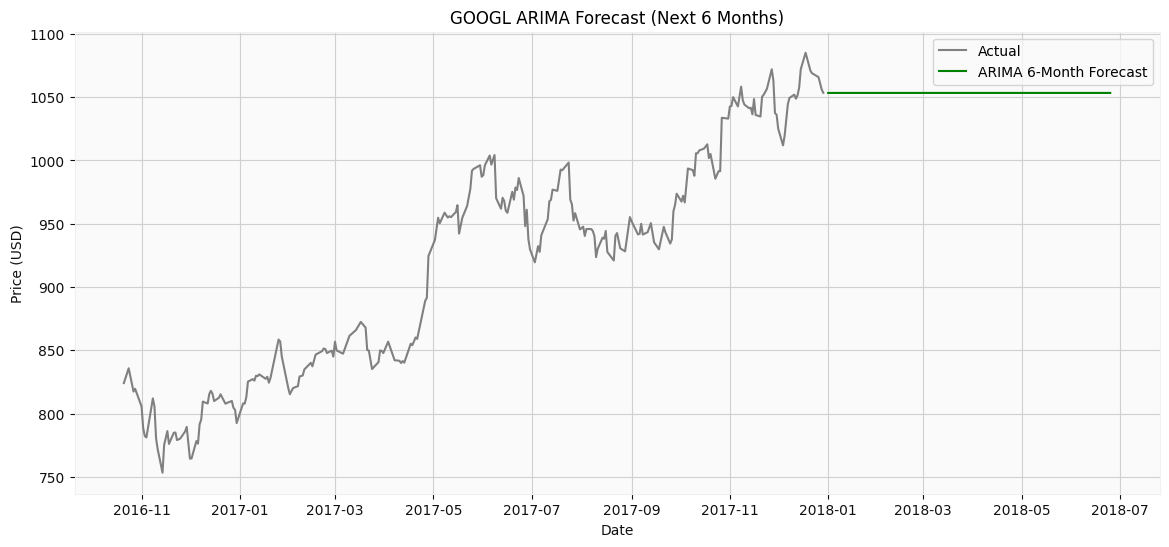

In [45]:
plt.figure(figsize=(14, 6))
plt.plot(df['Close'][-300:], label='Actual', color='gray')
plt.plot(forecast_index, forecast, label='ARIMA 6-Month Forecast', color='green')
plt.title('GOOGL ARIMA Forecast (Next 6 Months)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### LSTM Model for forecasting

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

2025-05-21 09:26:17.337586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747819577.536753      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747819577.594473      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [29]:
df = pd.read_csv('/kaggle/input/stock-time-series-20050101-to-20171231/GOOGL_2006-01-01_to_2018-01-01.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['Close']].dropna()

# Normalize prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Step 2: Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(scaled_data, window_size)

In [30]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape to (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [31]:
# Step 4: Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10


2025-05-21 09:27:35.272776: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0140
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 8.7228e-04
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 8.3023e-04
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 6.8365e-04
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 5.9941e-04
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 6.5840e-04
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 6.1027e-04
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 5.5607e-04
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 5.6164e-04
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.8148e-04


In [32]:
# Step 5: Predict on test data
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


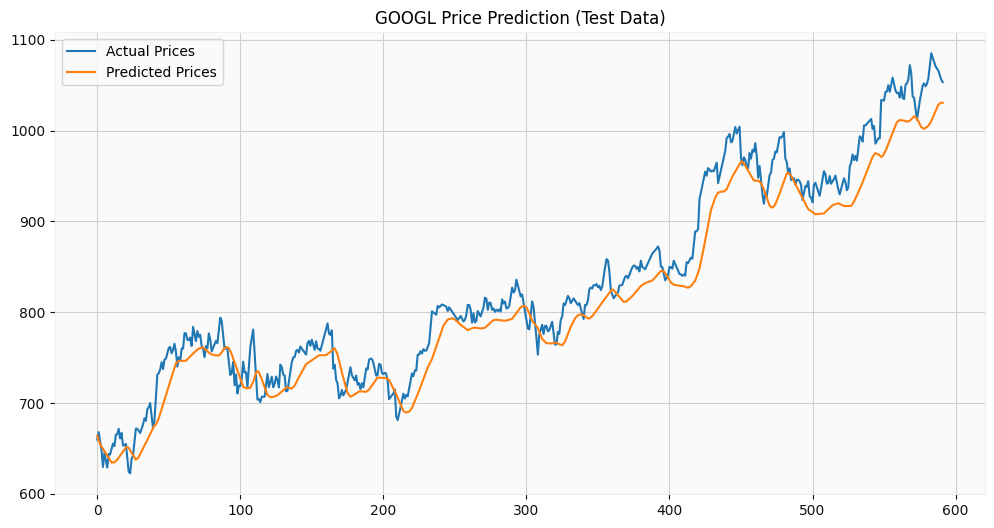

In [33]:
# Step 6: Plot test prediction
plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, label='Actual Prices')
plt.plot(y_pred_rescaled, label='Predicted Prices')
plt.title("GOOGL Price Prediction (Test Data)")
plt.legend()
plt.show()

In [34]:
#Predict future 30 days
last_60 = scaled_data[-window_size:]
future_input = last_60.reshape(1, window_size, 1)
future_predictions = []

for _ in range(30):
    next_pred = model.predict(future_input)[0][0]
    future_predictions.append(next_pred)
    future_input = np.append(future_input[:, 1:, :], [[[next_pred]]], axis=1)

# Inverse scale future predictions
future_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

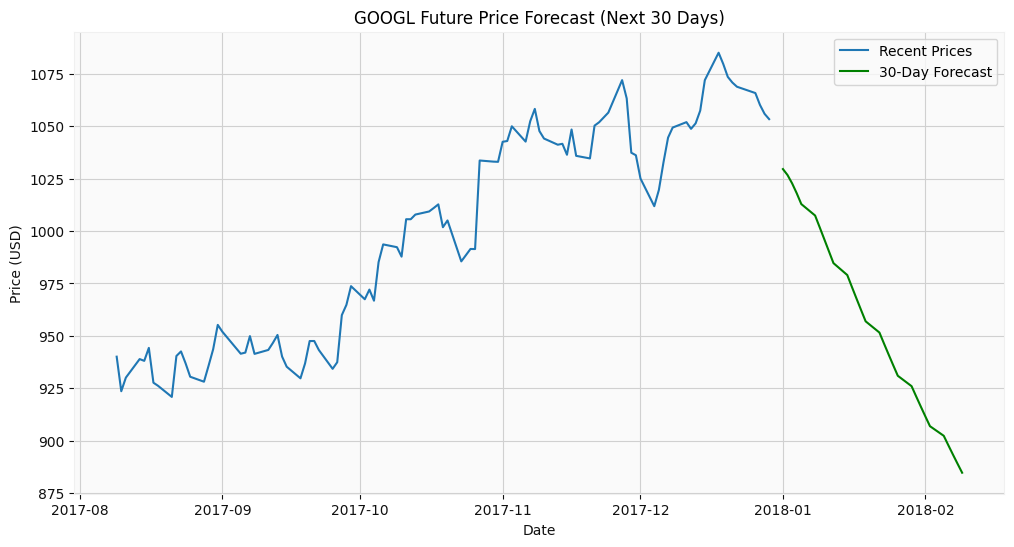

In [35]:
# Plot future prediction
last_date = df.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=30, freq='B')

plt.figure(figsize=(12,6))
plt.plot(df.index[-100:], df['Close'].values[-100:], label='Recent Prices')
plt.plot(future_dates, future_prices, label='30-Day Forecast', color='green')
plt.title("GOOGL Future Price Forecast (Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()